In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime

import QuantLib as ql
from scipy.optimize import minimize

current_time = pd.Timestamp(year=2021, month=8, day=3, hour=12)
current_price = 4300.

def delta_t(m):

    now = current_time
    delta_t = m - now
    year_dt = datetime.timedelta(365,0,0,0)

    return round(delta_t/year_dt, 6)

def date_pd_to_ql(date):
    date = pd.to_datetime(date)
    day = date.day
    month = date.month
    year = date.year

    return ql.Date(day, month, year)


df = pd.read_csv(r'spx_SABR.csv')

df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')
maturities = df['Date'].unique()

In [39]:
#PLOTTING

#Plot volatility Surface
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1, 3, 0.1), plot_strikes=np.arange(70, 130, 1), funct='blackVol'):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure(figsize=(20, 8))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('Implied Volatility')
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                          for x, y in zip(xr,yr) ]
                     ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.3)


def plot2d(x, y):
    fig = plt.figure(figsize=(6, 4), dpi=80)
    ax = fig.gca()

    ax.plot(x, y)

    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatility')
    ax.set_xbound(4000, 6000)

    plt.show()

def plot3d(x, y, z, rng=current_price, angle=45, scatter=True):
    fig = plt.figure(figsize=(15, 8), dpi=80)

    ax = plt.axes(projection='3d')
    if scatter:
        ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=.5)
    else:
        ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none');



    ax.set_xlabel('Maturities')
    ax.set_ylabel('Strikes')
    ax.set_zlabel('Implied Volatility')

    ax.set_ylim((current_price - rng, current_price + rng))
    
    ax.invert_xaxis()
    ax.view_init(20, angle)
    

    plt.show()


C:\Users\somig\AppData\Local\Temp/ipykernel_11056/508323395.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


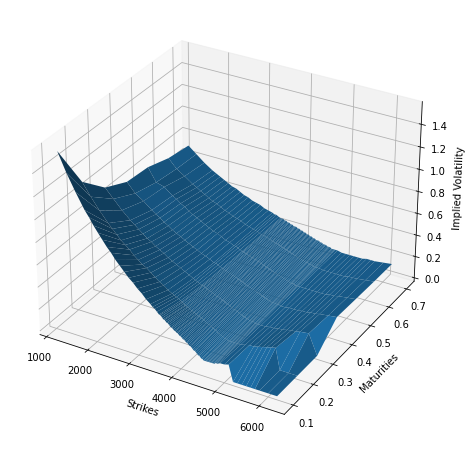

In [40]:
# BLACK VOLATILITY SURFACE

vols = [np.array(df[df["Date"] == maturities[m]]["IV"]) for m in range(len(maturities))]
volMatrix = ql.Matrix(len(vols[0]), len(vols))

for i in range(len(vols)):
    for j in range(len(vols[i])):
        volMatrix[j][i] = vols[i][j]

today = ql.Date(3, 8, 2021)
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()
dates = [date_pd_to_ql(d) for d in maturities]
strikes = df["Strike"].unique()

black_var_surface  = ql.BlackVarianceSurface(today, calendar, dates, strikes, volMatrix, day_count)
black_var_surface .enableExtrapolation()

plot_vol_surface(vol_surface=black_var_surface , plot_years=np.arange(0.1, .8, 0.1), plot_strikes=strikes, funct='blackVol')

In [41]:
#CALIBRATE VOLATILITY SURFACE

def volatilitySmileSABR(maturity, shift=0, beta=1):

    option = df[df["Date"] == maturity]
    dt = delta_t(pd.to_datetime(maturity))

    strikes = option["Strike"]
    fwd = current_price
    expiryTime = dt
    marketVols = option["IV"]*10**-2

    def set_beta():
        return beta

    x = [.1, set_beta(), .1, .1]

    def f(params):

        alpha, beta, nu, rho = params

        alpha = max(alpha, 1e-8) # Avoid alpha going negative
        beta = set_beta()
        nu = max(nu, 1e-8) # Avoid nu going negative
        rho = max(rho, -0.999) # Avoid rhp going < -1.0
        rho = min(rho, 0.999) # Avoid rho going > 1.0

        vols = np.array([
        ql.sabrVolatility(strike + shift, fwd + shift, expiryTime, alpha, beta, nu, rho)
        for strike in strikes
        ])

        error = ((vols - np.array(marketVols))**2 ).mean() **.5

        return error

    cons = (
    {'type': 'ineq', 'fun': lambda x: x[0]},
    # {'type': 'ineq', 'fun': lambda x: 0.99 - x[1]},
    # {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]},
    {'type': 'ineq', 'fun': lambda x: 1. - x[3]**2}
    )


    result = minimize(f, x, constraints=cons)
    error = result['fun']
    [alpha, beta, nu, rho] = result['x']

    newVols = [ql.sabrVolatility(strike, fwd, expiryTime, alpha, beta, nu, rho) for strike in strikes]
    
    return dict(vols=newVols, error=error, params={"alpha": alpha, "beta": beta, "nu": nu, "rho": rho})

def volatilitySurfaceSABR(method="normal", beta=1, shift=0):

    vol_surface_vector, errors, _alpha, _beta, _nu, _rho = [], [], [], [], [], []
    SABRVolMatrix = ql.Matrix(len(strikes), len(maturities))
    
    for i,m in enumerate(maturities):
        volSABR = volatilitySmileSABR(maturity=m, beta=beta, shift=shift)

        _alpha.append(volSABR["params"]["alpha"])
        _beta.append(volSABR["params"]["beta"])
        _nu.append(volSABR["params"]["nu"])
        _rho.append(volSABR["params"]["rho"])
        
        errors.append(volSABR["error"])

        smile = volSABR["vols"]
        vol_surface_vector.extend(smile)

        #constructing the SABRVolatilityMatrix
        for j in range(len(smile)):
            SABRVolMatrix[j][i] = smile[j]
    
    return dict(vols=vol_surface_vector, volMatrix=SABRVolMatrix, e=errors, a=_alpha, b=_beta, n=_nu, r=_rho)


C:\Users\somig\AppData\Local\Temp/ipykernel_11056/508323395.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


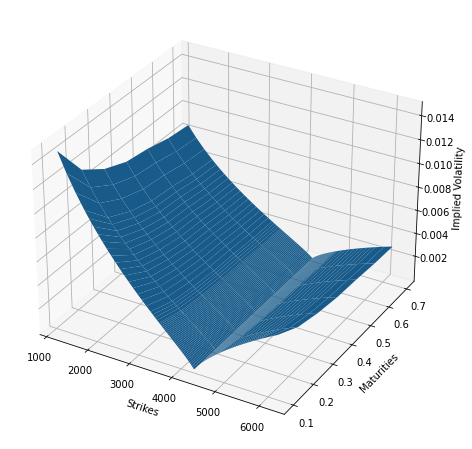

In [50]:
#SABR VOLATILITY SURFACE

SABRVolMatrix = volatility_surface["volMatrix"]

today = ql.Date(3, 8, 2021)
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()
dates = [date_pd_to_ql(d) for d in maturities]
strikes = df["Strike"].unique()

SABR_vol_surface  = ql.BlackVarianceSurface(today, calendar, dates, strikes, SABRVolMatrix, day_count)
SABR_vol_surface.enableExtrapolation()

plot_vol_surface(vol_surface=SABR_vol_surface , plot_years=np.arange(0.1, .8, 0.1), plot_strikes=strikes, funct='blackVol')
volatility_surface = volatilitySurfaceSABR()

,alpha,beta,nu,rho
2021-08-06,0.000076,1.0,0.532991,-0.999847
2021-08-09,0.000101,1.0,0.241653,0.097454
2021-08-11,0.000101,1.0,0.212868,0.099363
2021-08-13,0.000102,1.0,0.179974,0.100881
2021-08-16,0.000098,1.0,0.160935,0.102112
2021-08-20,0.000099,1.0,0.160724,0.102152
2021-08-23,0.000100,1.0,0.123366,0.102836
2021-08-25,0.000099,1.0,0.119275,0.102964
2021-08-27,0.000100,1.0,0.114522,0.103315
2021-09-10,0.000098,1.0,0.089890,0.104537


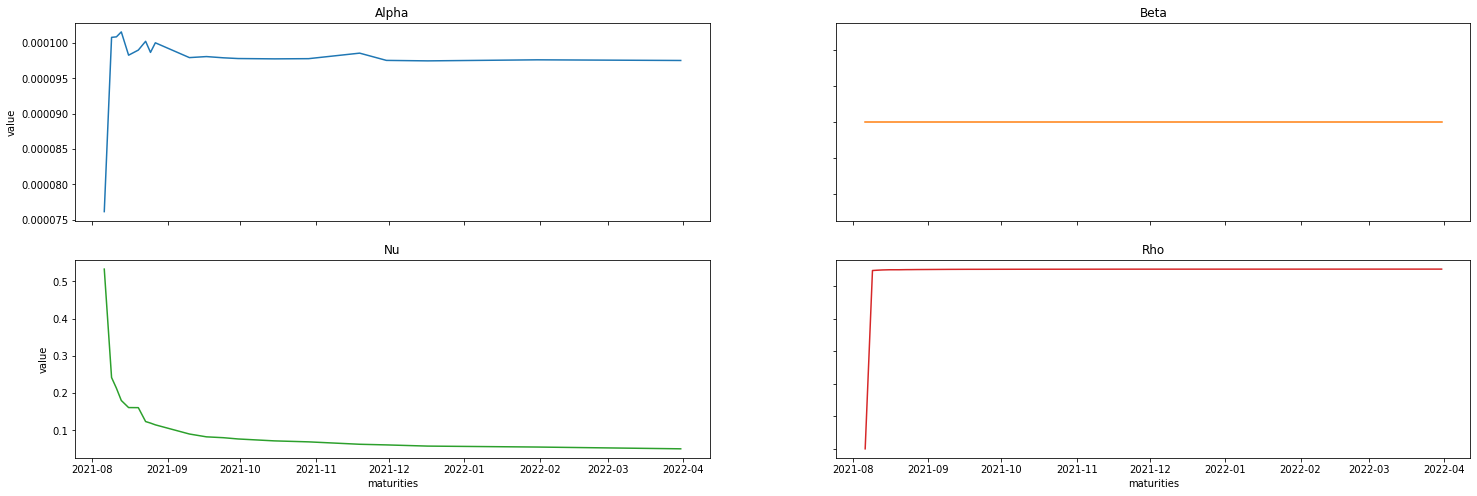

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(25,8))
axs[0, 0].plot(maturities, volatility_surface["a"])
axs[0, 0].set_title('Alpha')
axs[0, 1].plot(maturities, volatility_surface["b"], 'tab:orange')
axs[0, 1].set_title('Beta')
axs[1, 0].plot(maturities, volatility_surface["n"], 'tab:green')
axs[1, 0].set_title('Nu')
axs[1, 1].plot(maturities, volatility_surface["r"], 'tab:red')
axs[1, 1].set_title('Rho')

for ax in axs.flat:
    ax.set(xlabel='maturities', ylabel='value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

d = {'alpha': volatility_surface["a"], 'beta': volatility_surface["b"], 'nu': volatility_surface["n"], 'rho': volatility_surface["r"]}
pd.DataFrame(data=d, index=maturities)



In [44]:
method1 = volatilitySurfaceSABR(beta=1, shift=0)
method2 = volatilitySurfaceSABR(beta=.5, shift=0)
method3 = volatilitySurfaceSABR(method="free-boundary", beta=.1, shift=0)

plt.plot(method1["a"])
plt.plot(method2["a"])
plt.plot(method3["a"])

RuntimeError: rho square must be less than one: -1 not allowed

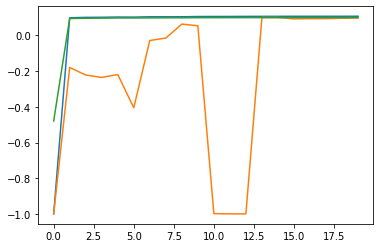

In [ ]:
method1 = volatilitySurfaceSABR(beta=1, shift=0)
method2 = volatilitySurfaceSABR(beta=.5, shift=0)
method3 = volatilitySurfaceSABR(method="free-boundary", beta=.1, shift=0)

plt.plot(method1["r"])
plt.plot(method2["r"])
plt.plot(method3["r"])

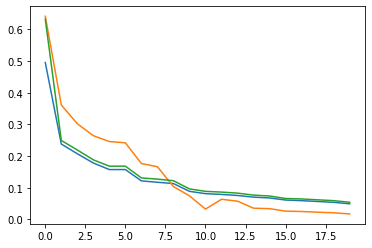

In [ ]:
method1 = volatilitySurfaceSABR(beta=1, shift=0)
method2 = volatilitySurfaceSABR(beta=.5, shift=0)
method3 = volatilitySurfaceSABR(method="free-boundary", beta=.1, shift=0)

plt.plot(method1["n"])
plt.plot(method2["n"])
plt.plot(method3["n"])

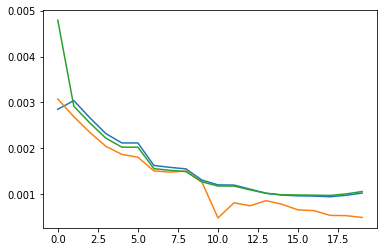

In [ ]:
plt.plot(method1["e"])
plt.plot(method2["e"])
plt.plot(method3["e"])

C:\Users\somig\AppData\Local\Temp/ipykernel_11056/4064406799.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


RuntimeError: decreasing variance at strike 1200 between time 0.1 and time 0.1001

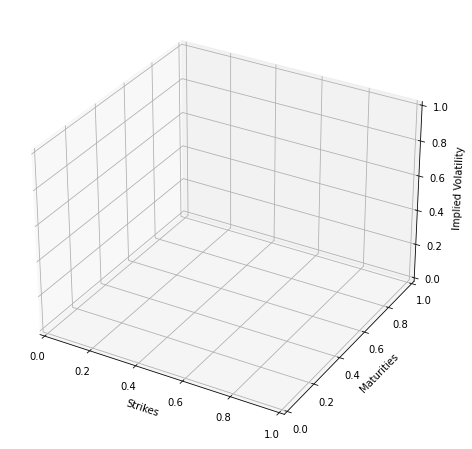

In [ ]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

spot_quote = ql.QuoteHandle(ql.SimpleQuote(current_price))

rate = 0.0
riskFreeCurve = ql.FlatForward(today, rate, ql.Actual365Fixed())
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)


black_var_surface .setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)
local_vol_surface = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)

# Plot the Dupire surface ...
local_vol.enableExtrapolation()
plot_vol_surface(local_vol_surface, plot_years=np.arange(0.1, .8, 0.1), plot_strikes=strikes, funct='localVol')
